In [1]:
import pandas as pd
import numpy as np
import pydicom 
import os
import matplotlib.pyplot as plt

from skimage.measure import label,regionprops
from skimage.segmentation import clear_border

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv('sample_submission.csv')

In [3]:
def load_scans(path):
    slices = [pydicom.dcmread(path + '/' + file) for file in os.listdir(path)]
    slices.sort(key = lambda x : float(x.ImagePositionPatient[2]))
    return slices

In [4]:
def lung_slices_pic(slices):
    slices_3d = []
    for slc in slices:
        tmp_dicom = slc.pixel_array
        img = (tmp_dicom + slc.RescaleIntercept)/ slc.RescaleSlope
        img = img < -400
        img = clear_border(img)
        
        img = label(img)
        
        areas = [r.area for r in regionprops(img)]
        areas.sort()
        if len(areas) > 2:
            for region in regionprops(img):
                if region.area < areas[-2]:
                    for coordinates in region.coords:                
                        img[coordinates[0], coordinates[1]] = 0
        img = img > 0
        
        
        slices_3d.append(img*tmp_dicom)
        
    return np.array(slices_3d)

In [5]:
def best_slice(array):
    tmp_best = array[0]
    pixel_nr = 0
    for i in range(1,array.shape[0]):
        if (array[i]!=0).sum() > pixel_nr:
            tmp_best = array[i]
            pixel_nr = (array[i]!=0).sum()
    return tmp_best

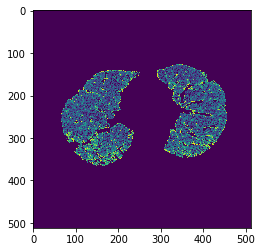

In [6]:
example = 'train/' + train['Patient'][0]
example_3d = lung_slices_pic(load_scans(example))

plt.imshow(best_slice(example_3d))

In [6]:
patients = train.Patient.unique()

In [7]:
train_ct = pd.DataFrame(index=patients, columns=['CT'])

In [9]:
for ind in patients:
    train_ct.loc[ind].CT = best_slice( lung_slices_pic(load_scans( 'train/' + ind  )) )

AttributeError: 'FileDataset' object has no attribute 'ImagePositionPatient'

In [ ]:
train_ct.to_csv('train_CT.csv')